# Import Libraries

In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

print(os.listdir("../input"))

/kaggle/input/fer2013/fer2013.csv
/kaggle/input/fer2018/fer20131.csv
/kaggle/input/fer2018/README
/kaggle/input/fer2018/fer2013.bib
/kaggle/input/fer2018/ferSubmission.csv
['fer2013', 'fer2018']


# Dataset 

In [30]:
data = pd.read_csv('../input/fer2013/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [31]:
# view first 5 rows of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [32]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [33]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


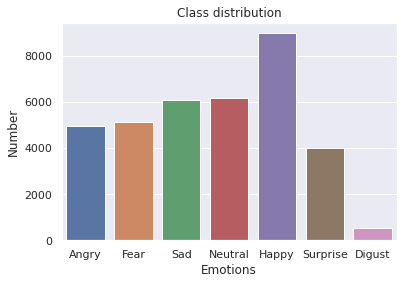

In [34]:


# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

Looking at some images from the dataset...

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


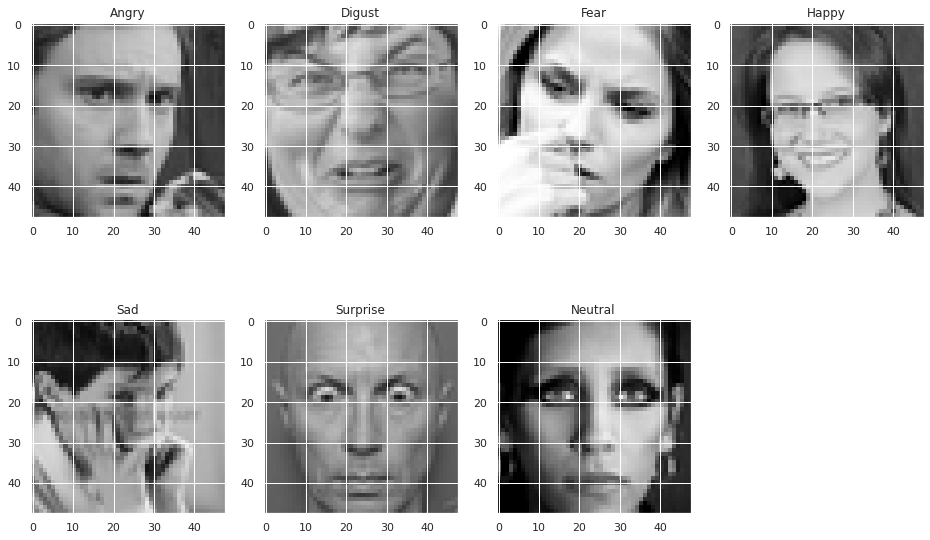

In [35]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

# Pre-processing Data

In [36]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


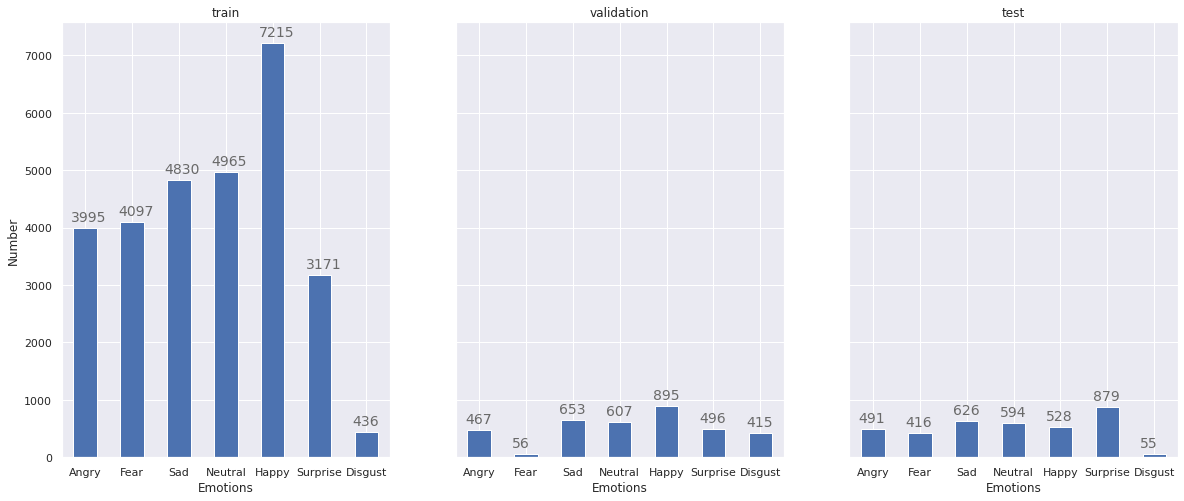

In [37]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry','Fear','Sad','Neutral','Happy','Surprise','Disgust']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [38]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [39]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

x_test =test_X
y_test=test_Y


train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


# Building CNN Model
**CNN Architecture**

    Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
    Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
    Conv -> BN -> Activation -> Conv -> BN -> Activation -> MaxPooling
    Flatten
    Dense -> BN -> Activation
    Dense -> BN -> Activation
    Dense -> BN -> Activation
    Output layer

In [40]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_5 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_5 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_6 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_6 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 256)      

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [41]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
448/448 - 26s - loss: 1.6863 - accuracy: 0.3289 - val_loss: 1.7261 - val_accuracy: 0.3232
Epoch 2/50
448/448 - 23s - loss: 1.3939 - accuracy: 0.4600 - val_loss: 1.3378 - val_accuracy: 0.4798
Epoch 3/50
448/448 - 23s - loss: 1.2527 - accuracy: 0.5218 - val_loss: 1.2010 - val_accuracy: 0.5344
Epoch 4/50
448/448 - 23s - loss: 1.1768 - accuracy: 0.5510 - val_loss: 1.2303 - val_accuracy: 0.5227
Epoch 5/50
448/448 - 23s - loss: 1.1263 - accuracy: 0.5746 - val_loss: 1.4095 - val_accuracy: 0.4974
Epoch 6/50
448/448 - 23s - loss: 1.0870 - accuracy: 0.5879 - val_loss: 1.2278 - val_accuracy: 0.5333
Epoch 7/50
448/448 - 23s - loss: 1.0540 - accuracy: 0.6005 - val_loss: 1.9407 - val_accuracy: 0.3447
Epoch 8/50
448/448 - 23s - loss: 1.0292 - accuracy: 0.6112 - val_loss: 1.1985 - val_accuracy: 0.5631
Epoch 9/50
448/448 - 23s - loss: 1.0075 - accuracy: 0.6198 - val_loss: 1.0872 - val_accuracy: 0.5991
Epoch 10/50
448/448 - 23s - loss: 0.9812 - accuracy: 0.6277 - val_loss: 1.2684 - val_accura

# Visualise training performance

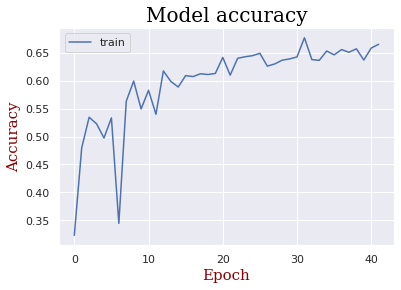

In [53]:
font1 = {'family':'serif','color':'black','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
cm = plt.figure(figsize = (6,4))
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy',  fontdict = font1)
plt.ylabel('Accuracy', fontdict = font2)
plt.xlabel('Epoch', fontdict = font2)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
cm.savefig("model_acc")


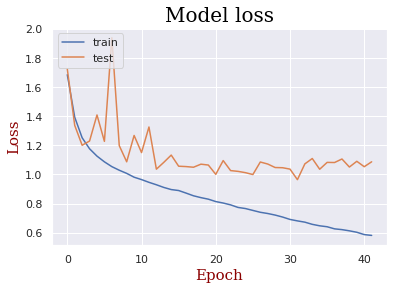

In [54]:
# summarize history for loss
cm = plt.figure(figsize = (6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss',  fontdict = font1)
plt.ylabel('Loss', fontdict = font2)
plt.xlabel('Epoch' , fontdict = font2)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
cm.savefig("model_loss")

# Evaluate Test performance

In [48]:
x_test =test_X
y_test=test_Y

In [51]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6721


In [45]:
print(classification_report(np.argmax(test_Y, axis=1), test_pred, target_names=['Angry','Fear','Sad','Neutral','Happy','Surprise','Disgust']))



              precision    recall  f1-score   support

       Angry       0.64      0.56      0.60       491
        Fear       0.66      0.71      0.68        55
         Sad       0.57      0.42      0.48       528
     Neutral       0.86      0.88      0.87       879
       Happy       0.51      0.57      0.54       594
    Surprise       0.79      0.76      0.78       416
     Disgust       0.59      0.72      0.65       626

    accuracy                           0.67      3589
   macro avg       0.66      0.66      0.66      3589
weighted avg       0.67      0.67      0.67      3589



# Confusion Matrix

In [49]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[0, 5, 6, 4, 2, 0, 4, 3, 0, 3]

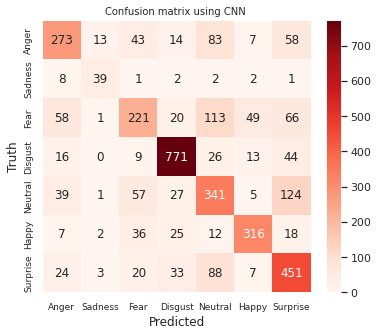

In [55]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (6,5))
ax = plt.axes()
sn.heatmap(cm,cmap="Reds", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"], fontsize=9);
ax.yaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"],  fontsize=9);

plt.title('Confusion matrix using CNN ', fontsize = 10, fontweight=500)
plt.xlabel('Predicted')
plt.ylabel('Truth')
# plt.supxlabel(["Happy", "Surprise", "Anger", "Sadness", "Fear"], fontsize=9);
# ax.yaxis.set_ticklabels(["Happy", "Surprise", "Anger", "Sadness", "Fear"],  fontsize=9);

plt.savefig("confusion")

In [57]:
print(y_pred)
y_test =  np.argmax(y_test,axis=1)
predict_x = model.predict(x_test)
# Y_Pred = np.argmax(predict_x,axis=1)
print(predict_x[:,2])

[[4.23903137e-01 1.78949386e-01 1.30783156e-01 ... 1.75326377e-01
  1.91216823e-02 7.16443062e-02]
 [1.72547877e-01 6.29268106e-05 2.67687231e-01 ... 4.10293490e-01
  2.98123751e-02 1.48086250e-02]
 [3.74540687e-02 5.84920008e-06 6.54492795e-01 ... 2.23604724e-01
  1.56710448e-05 8.44236165e-02]
 ...
 [1.03181206e-01 2.18189947e-04 1.90988883e-01 ... 4.42439735e-01
  1.39407965e-03 2.61679828e-01]
 [7.01826066e-04 1.78642324e-06 6.06624963e-05 ... 2.86506722e-03
  1.77414462e-04 2.93865893e-03]
 [1.01838388e-01 3.03293316e-04 3.84092003e-01 ... 3.22804391e-01
  1.88767546e-04 1.90436944e-01]]
[1.3078316e-01 2.6768723e-01 6.5449280e-01 ... 1.9098888e-01 6.0662496e-05
 3.8409200e-01]


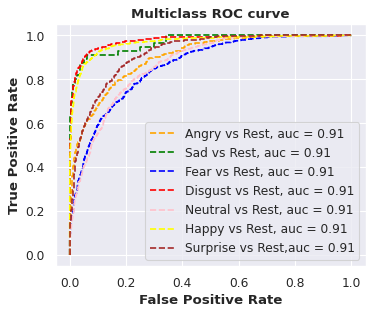

In [58]:
### ROC Curve
# roc curve for classes
from sklearn import metrics
fpr = {}
tpr = {}
thresh ={}
auc = {}
y_prob_pred_cnb = predict_x

n_class = 7
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = metrics.roc_curve(y_test, y_prob_pred_cnb[:,i], pos_label=i)
    auc[i] = metrics.roc_auc_score(y_test,y_prob_pred_cnb,multi_class='ovr',average='weighted')
    
plt.figure(figsize=(5, 4),dpi=80)
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Angry vs Rest, auc = '+str(auc[0])[:4])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Sad vs Rest, auc = '+str(auc[1])[:4])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Fear vs Rest, auc = '+str(auc[2])[:4])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Disgust vs Rest, auc = '+str(auc[3])[:4])
plt.plot(fpr[4], tpr[4], linestyle='--',color='pink', label='Neutral vs Rest, auc = '+str(auc[4])[:4])
plt.plot(fpr[5], tpr[5], linestyle='--',color='yellow', label='Happy vs Rest, auc = '+str(auc[5])[:4])
plt.plot(fpr[6], tpr[6], linestyle='--',color='brown', label='Surprise vs Rest,auc = '+str(auc[6])[:4])
plt.title('Multiclass ROC curve',fontsize=12,fontweight='bold')
plt.xlabel('False Positive Rate',fontsize=12,fontweight='bold')
plt.ylabel('True Positive Rate',fontsize=12,fontweight='bold')
plt.legend(loc='best')
plt.savefig('CNN_LSTM_Multiclass_ROC.png',dpi=80);    